This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

### This is using compensated images
- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from autoencoder import network
from autoencoder import utils

%matplotlib inline
%pwd

'/media/cjw/PythonLib/cjwdeeplearning/autoencoder/Channels_0_1_3_4'

In [2]:
datadir =  '/media/cjw/Data/cyto/mmFromTifs3/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'

cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS128/checkpoint-2018-04-25-10-43-45/"
aemeta = 'autoencoder-128x-27960.meta'

if os.path.exists(cp_dir + aemeta):
    print("OK")

OK


In [3]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
print(cp_dir)

if os.path.exists(cp_dir):
    print("OK, exists")
else:
    print("Oh no")
#checkpoint-2018-03-02-16-31-42/'
p_width = 32
p_height = 32
p_nchannels = 4
p_channels = [0,1,3,4]
p_nepochs = 120
p_batchsize = 128
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 128
p_droprate = 0.95
p_stdev = .04

enc_sizes = [(128, 3), (256, 3), (512, 3)] 
#enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network.ae_loss(images, sdd)

opt = network.model_opt(loss, p_learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS128/checkpoint-2018-04-25-10-43-45/
OK, exists
Encoder False
isize:  4 32
dh0 (?, 32, 32, 4)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS128/checkpoint-2018-04-25-10-43-45/autoencoder-128x-27960


In [5]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=.1)
df = df.reset_index()
print(len(df))
df.tail()

10000
10000
10000
3000


,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run
2995,12470,0,2470,0,Fish6_ICE,12470,Fish6_ICE.mm,0,0,0,32,32,ice,Fish6
2996,25958,0,5958,0,Fish6_CCB,25958,Fish6_CCB.mm,0,0,0,32,32,ccb,Fish6
2997,22719,0,2719,0,Fish6_CCB,22719,Fish6_CCB.mm,0,0,0,32,32,ccb,Fish6
2998,9205,0,9205,0,Fish6_Untreated,9205,Fish6_Untreated.mm,0,0,0,32,32,untreated,Fish6
2999,29254,0,9254,0,Fish6_CCB,29254,Fish6_CCB.mm,0,0,0,32,32,ccb,Fish6


In [6]:
sns.set_style("whitegrid", {'axes.grid' : False})

(3000, 128) (3000, 32, 32, 4)
0.0714315846562 0.975987315178


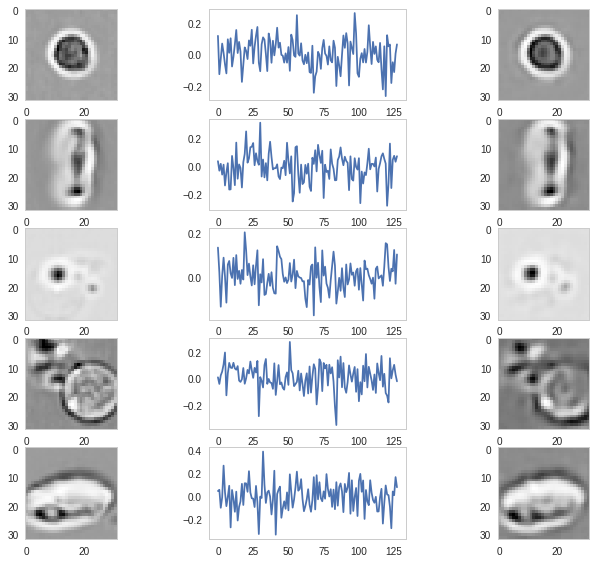

In [7]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0])
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0])
   

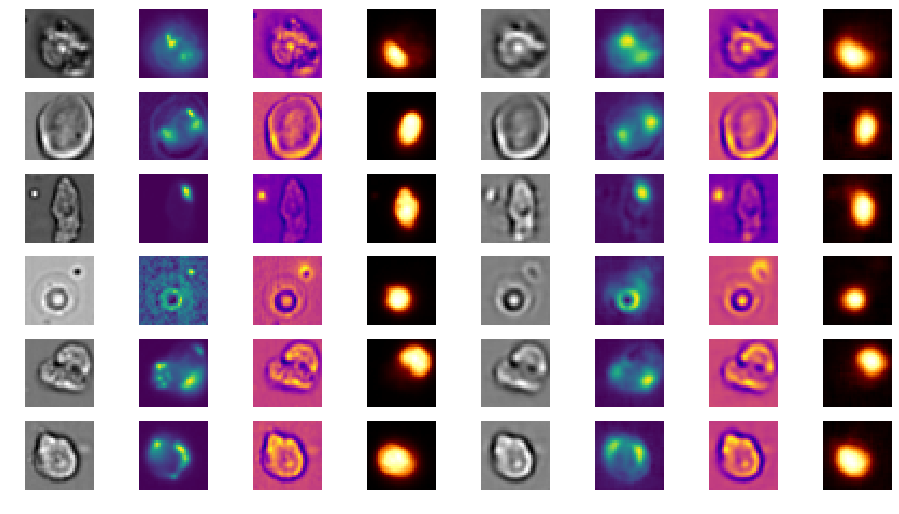

In [8]:
def one_imshow(image, r, c, ic, cmap):
    plt.subplot(16, 8, ic)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

ic = 1

nrows = 6
plt.figure(figsize=(16,4*nrows))

for i in range(nrows):
    ix = np.random.randint(0, len(vv))
    one_imshow(vv[ix,:,:,0], nrows, 8, ic, 'gray')
    ic += 1
    
    one_imshow(vv[ix,:,:,1], nrows, 8, ic, 'viridis')
    ic += 1
    
    one_imshow(vv[ix,:,:,2], nrows, 8, ic, 'plasma')
    ic += 1
    
    one_imshow(vv[ix,:,:,3], nrows, 8, ic, 'afmhot')
    ic += 1
    
    one_imshow(xdd[ix,:,:,0], nrows, 8, ic, 'gray')
    ic += 1
    
    one_imshow(xdd[ix,:,:,1], nrows, 8, ic, 'viridis')
    ic += 1
    
    one_imshow(xdd[ix,:,:,2], nrows, 8, ic, 'plasma')
    ic += 1
    
    one_imshow(xdd[ix,:,:,3], nrows, 8, ic, 'afmhot')
    ic += 1

plt.savefig('/media/cjw/Data/cyto/output/decoded.png')

In [9]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
3000
hek (3000, 128)
0 0 (3000, 128) (3000, 128)


(3000, 128)

In [10]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.] 10


In [11]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=18, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(3000, 18)
[ 0.05872245  0.05516852  0.04359873  0.03669761  0.03244218  0.02724768
  0.02668023  0.02484033  0.02242983  0.02180333  0.02093592  0.01928266
  0.01753683  0.01649781  0.01586726  0.01473572  0.01441109  0.01428633]
(18, 128)


In [12]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 16
from sklearn import cluster

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

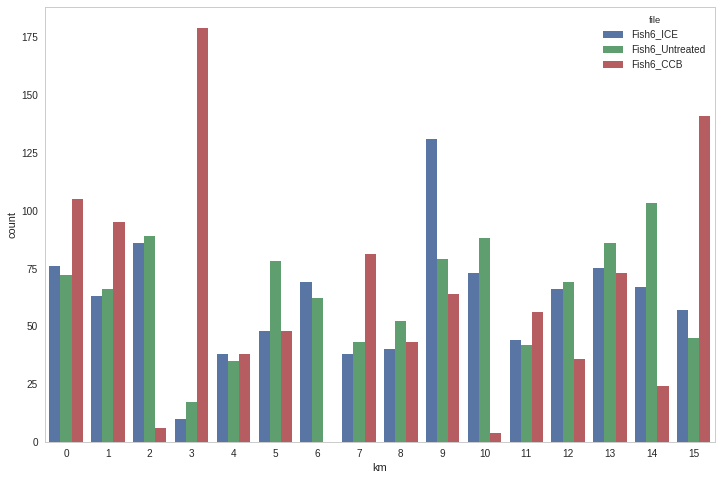

In [13]:
df['km'] = km

plt.figure(figsize=(12,8))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='km', data=df, hue='file')

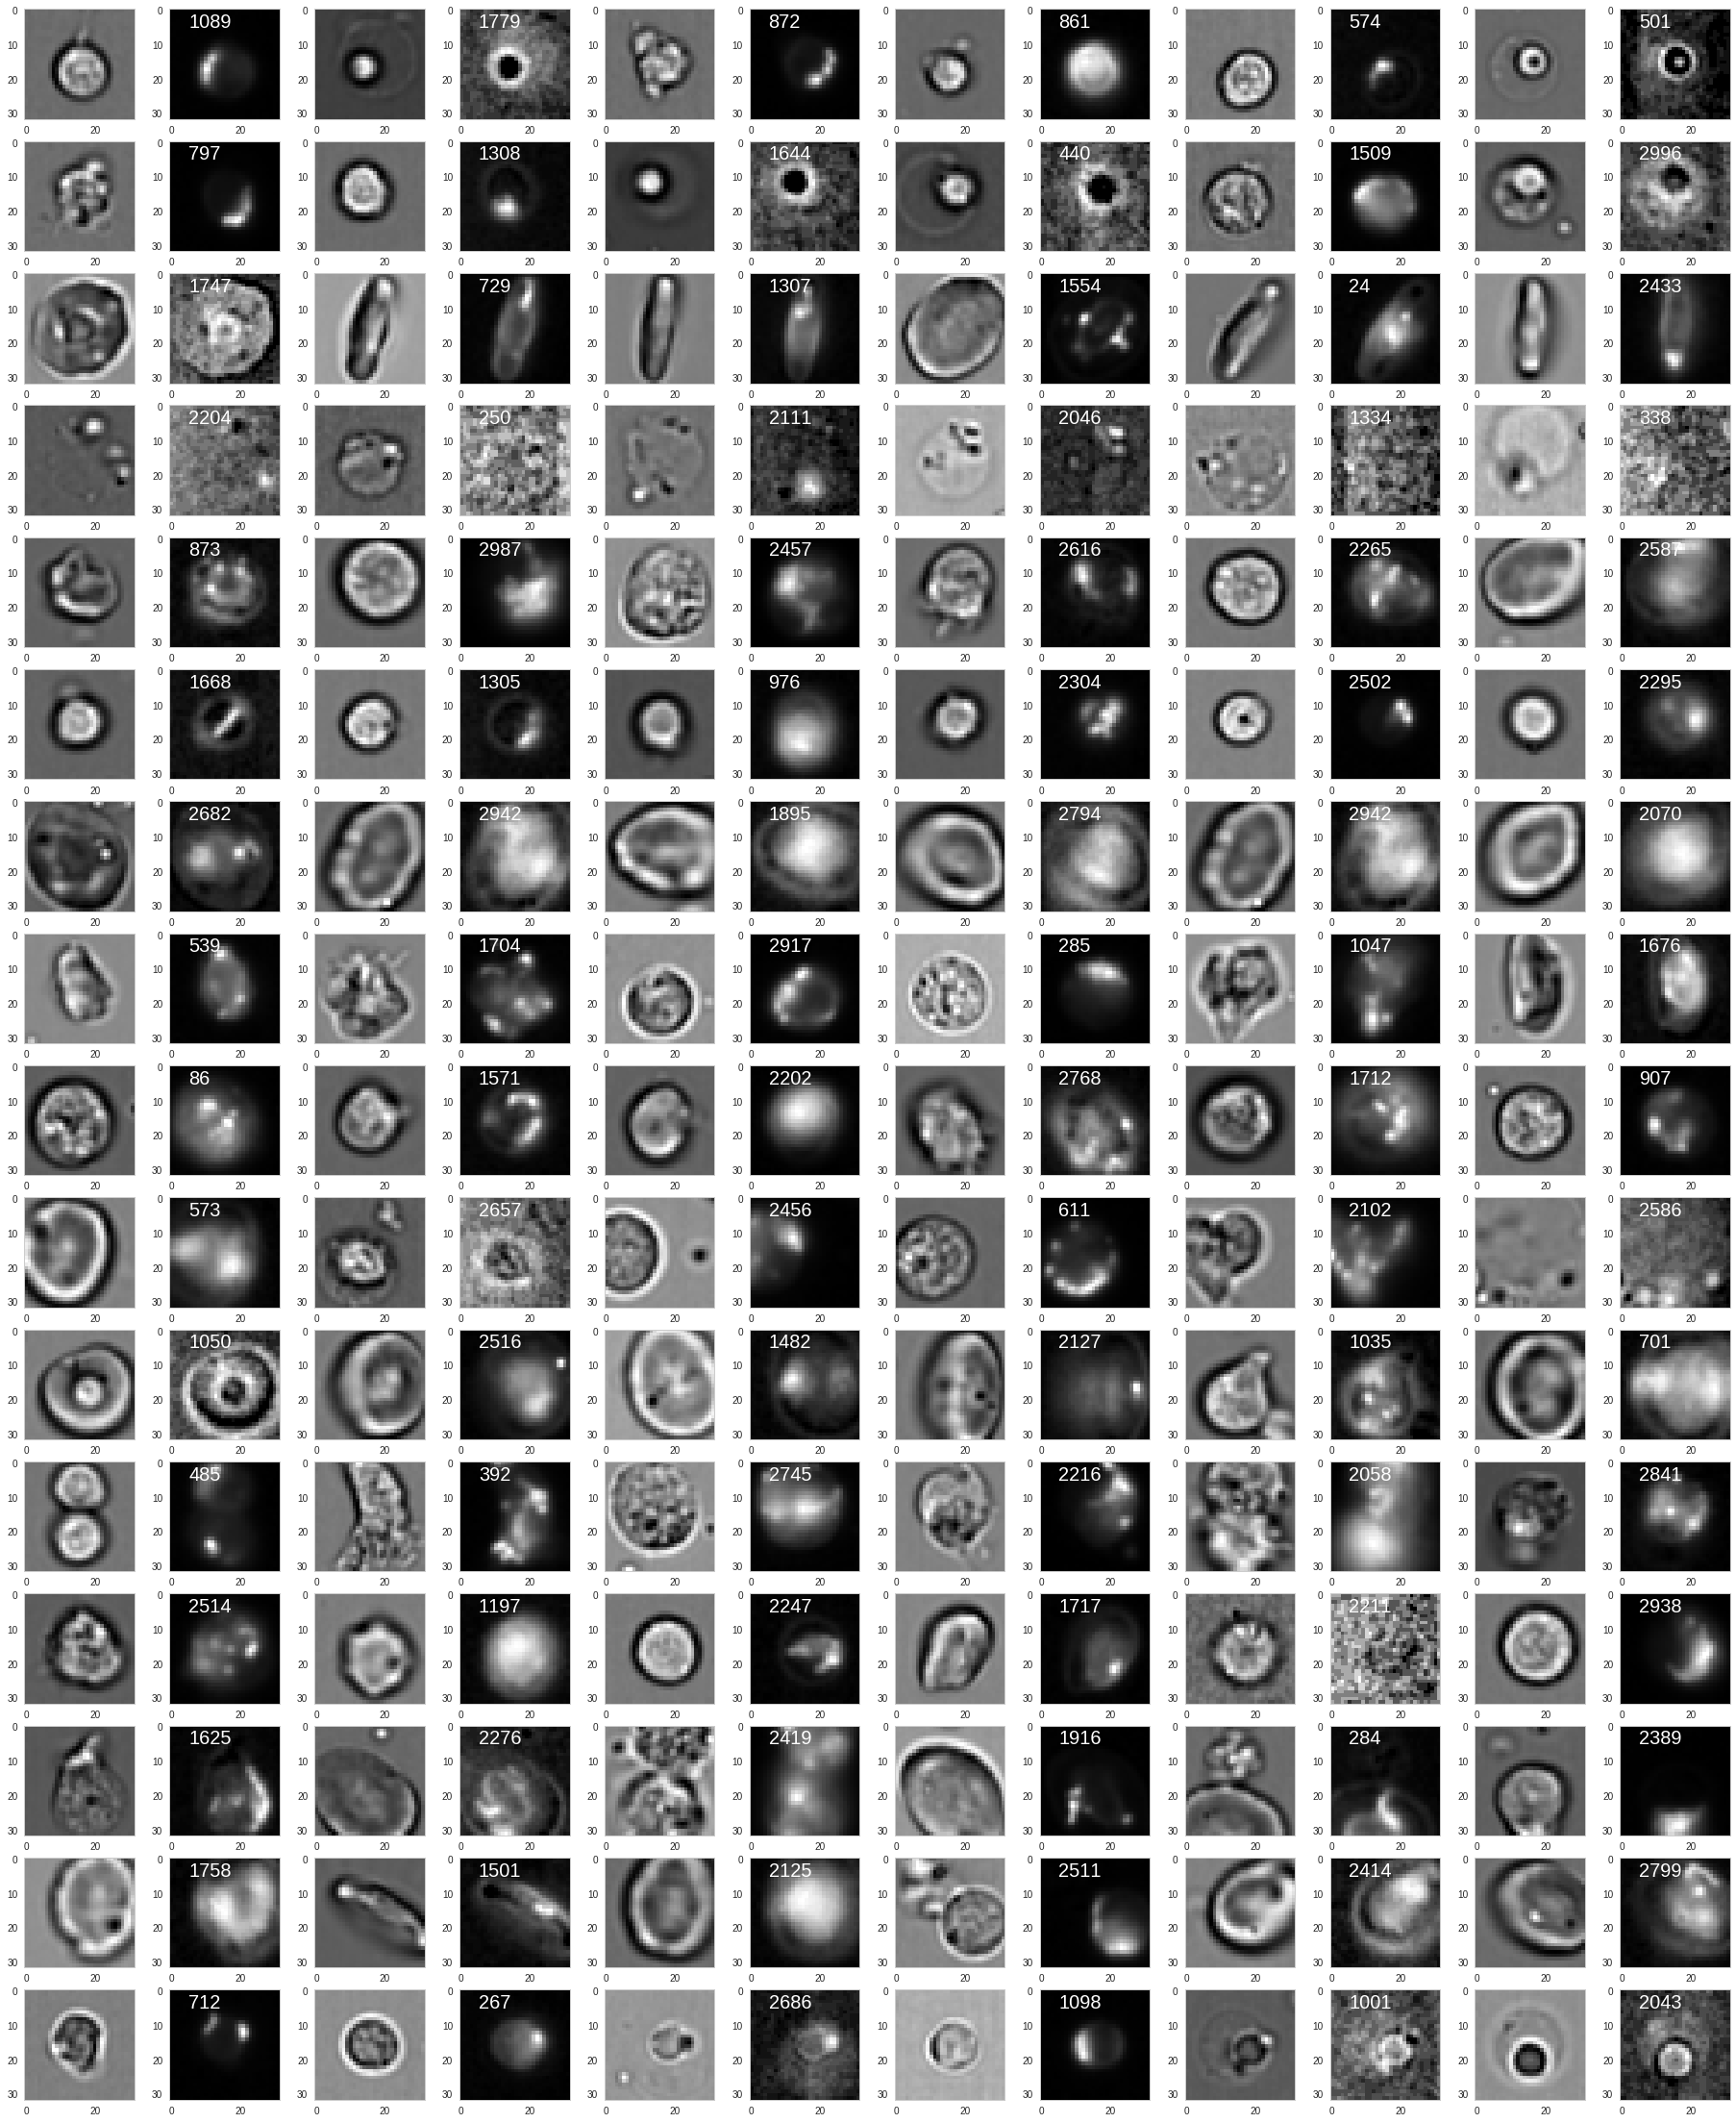

In [14]:
ximages = vv
ximages.shape

nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    #row = ximages[km == k]
    rowdf = df[df['km'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[km == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='white')
#     counter += 1
    for i in range(6):
        
        try:
            plt.subplot(nk, 12, counter)
            counter += 1
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            
            plt.subplot(nk, 12, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='gray')
            plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except:
            plt.imshow(np.zeros((64,64)))
            counter += 1

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

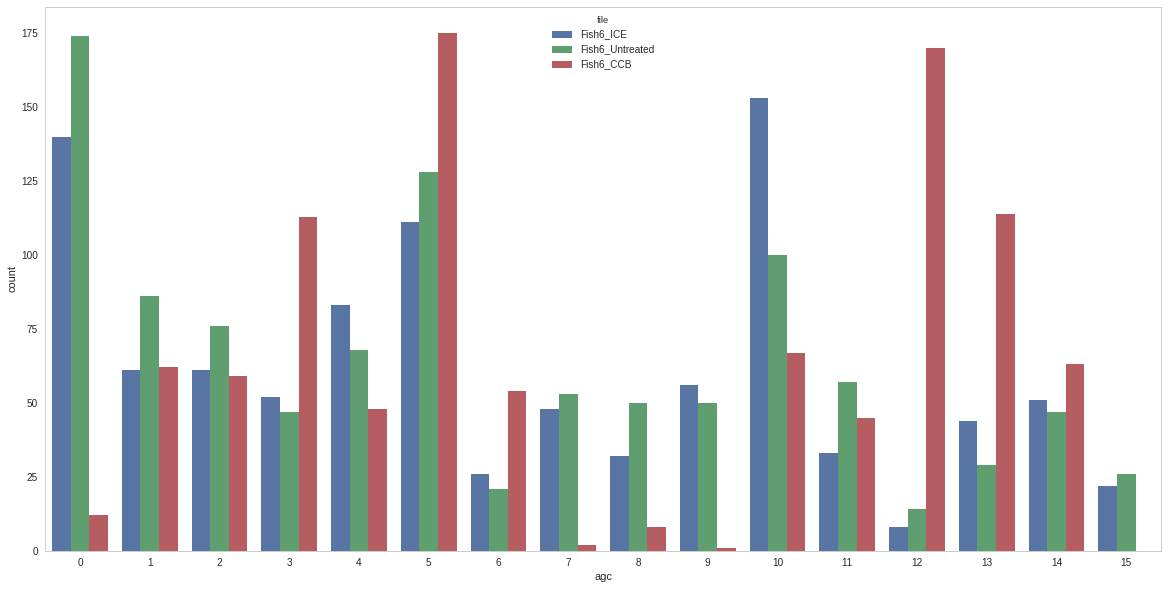

In [15]:
df['agc'] = agc
plt.figure(figsize=(20,10))
sns.countplot(x='agc', data=df, hue='file')
plt.savefig('/media/cjw/Data/cyto/output/agc_filedist.png')

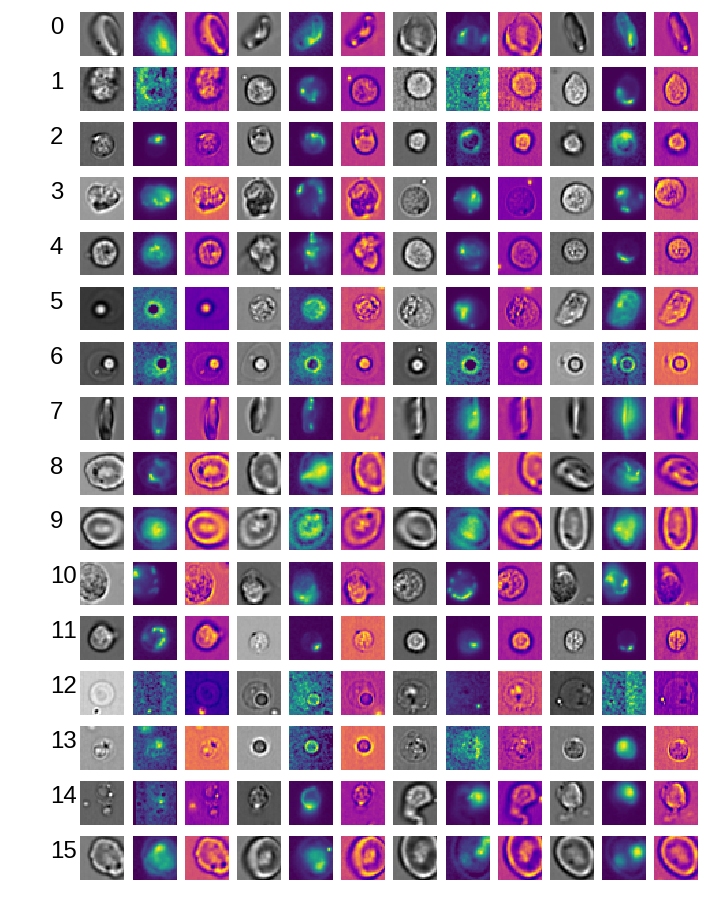

In [16]:
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='plasma')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except:
            plt.imshow(np.zeros((64,64)))
            counter += 1

-------------------------------------------------------------------------

In [17]:
import matplotlib 
def display_cluster(cluster_num, nrows=16, outfile=None):
    
    if outfile:
        plt.ioff()
    tn = cluster_num
    images4 = ximages[agc == tn]
    g4 = g_all[agc == tn]
    fig = plt.figure(figsize=(16,1.6*1.5*nrows))
    #print(images4.shape)

#     gtest = np.mean(g4, axis=0)
#     gtest = np.expand_dims(gtest.squeeze(), axis=0)
#     res = sess.run(sdd, feed_dict={enc:gtest})

#     gav = np.mean(g_all, axis=0)
#     gav = np.expand_dims(gav.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gav})

    ppi = 0
    for i in range(nrows):
        ix = np.random.randint(0, len(g4))
        plt.subplot(nrows,8,i*8 + 1)
        plt.imshow(images4[ix,:,:,0], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 2)
        plt.imshow(images4[ix,:,:,1], cmap='viridis')
        plt.axis('off')

        plt.subplot(nrows,8, i*8 + 3)
        plt.imshow(images4[ix,:,:,2], cmap='plasma')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 4)
        plt.imshow(images4[ix,:,:,3], cmap='afmhot')
        plt.axis('off')

        plt.subplot(nrows, 2, i*2 + 2)
        plt.plot(g4[ix]*0, color='gray')
        plt.plot(g4[ix])

    #     plt.xticks([])
    #     plt.yticks([])
        plt.axis('off')
        ppi += 2
    if outfile:
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(4, 10)
        #fig.savefig('test2png.png', dpi=100)
        plt.savefig(outfile, dpi=100)
        plt.clf()
        plt.close(fig)
    
    plt.ion()



In [18]:
for i in range(nclust):
    outfile = "/media/cjw/Data/cyto/output/cluster_" + str(i).zfill(3) + ".png"
    display_cluster(i, 8, outfile=outfile)

In [19]:
from sklearn.manifold import TSNE

# geez = list()
# ceez = list()
# cindex = 0
# for i in (16,17, 18,19):
#     gna = g_all[agc == i]
#     ca = cindex #np.array(clist[cindex])
#     cna = np.repeat([i], gna.shape[0], axis=0)
#     geez.append(gna)
#     ceez.append(cna)
#     cindex += 1
# # c3 = gn3.shape[0]*(1, 0, 0)
# # c6 = gn3.shape[0]*(0, 1, 0)
# # c10 = gn3.shape[0]*(0, 0, 1)
# gn = np.concatenate(geez)
# cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
#print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=50, learning_rate=1000).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)



(3000, 2)


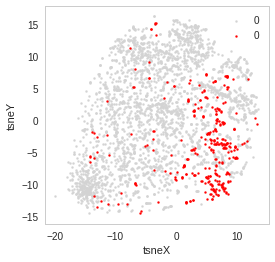

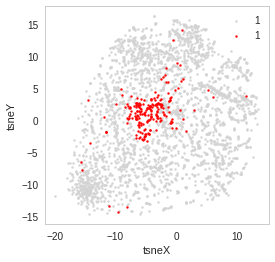

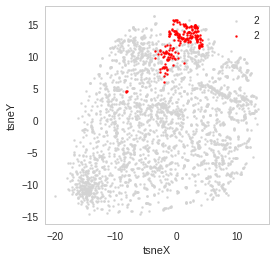

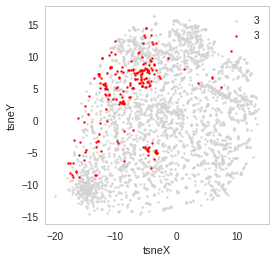

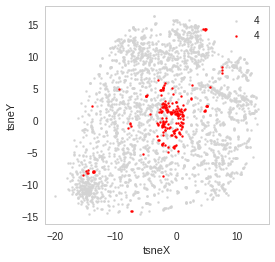

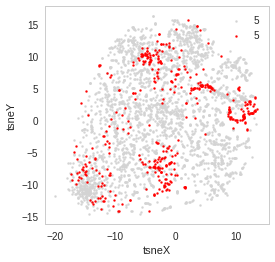

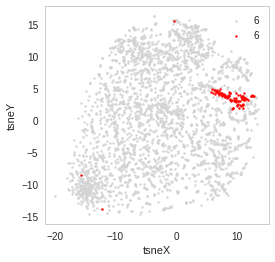

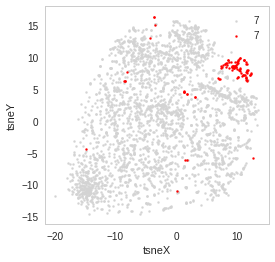

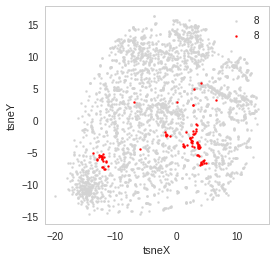

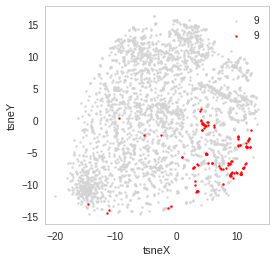

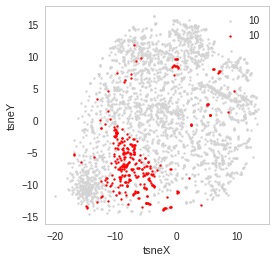

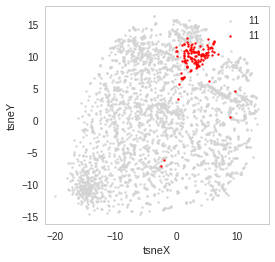

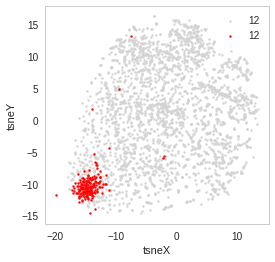

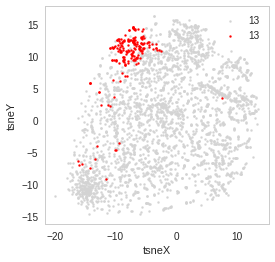

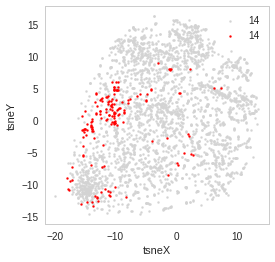

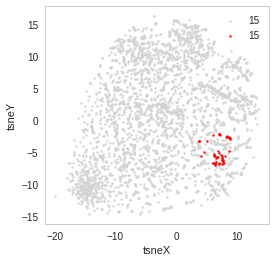

In [20]:
df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]

cs = ['black', 'gray', 'navy', 'blue',
      'slateblue', 'darkgreen', 'green', 'greenyellow',
     'gold', 'saddlebrown', 'salmon', 'orange']
ax = None

coi1 =  1
coi2 =  11
#plt.ioff()
for i in range(nclust):
        ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='lightgray', figsize=(4,4))
        df[df['agc'] == i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='red', ax = ax)
        outfile = "/media/cjw/Data/cyto/output/tsne_" + str(i).zfill(3) + ".png"
        plt.savefig(outfile, dpi=100)
        #plt.clf()
        #plt.close()
plt.ion()

KeyboardInterrupt: 

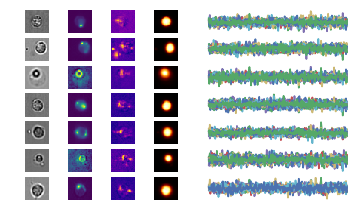

<class 'numpy.ndarray'>


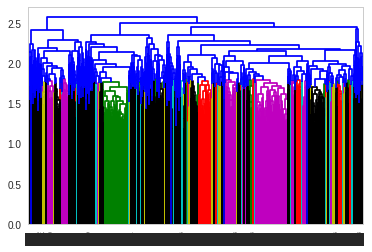

In [72]:
from scipy import cluster
Z = cluster.hierarchy.linkage(g_all, "complete")
print(type(Z))
cluster.hierarchy.dendrogram(Z);

In [1]:
cut = cluster.hierarchy.fcluster(Z, 2.5, criterion='distance')

df['cut'] = cut
plt.figure(figsize=(12,8))
sns.countplot(x='cut', data=df, hue='file')

NameError: name 'cluster' is not defined